# Question1 
Based on this data, what can we conclude at this point from the A/B test (in which we tried initiating the background check earlier in the hiring process for the treatment shoppers)? And how confident should we be in this conclusion?


## Data exploratory

In [1]:
# import package
import pandas as pd

In [2]:
# read file
df = pd.read_csv('application.csv')

# check dataset
df.head()

,applicant_id,channel,group,city,event,event_date
0,10001,web-search-engine,control,Asgard,application_date,2018-10-01
1,10002,social-media,control,Midgard,application_date,2018-10-01
2,10003,web-search-engine,treatment,Midgard,application_date,2018-10-01
3,10004,social-media,treatment,Asgard,application_date,2018-10-01
4,10005,social-media,treatment,Midgard,application_date,2018-10-01


In [3]:
# check datatype
print (df.dtypes)

# check len and column number
print (df.shape)

applicant_id     int64
channel         object
group           object
city            object
event           object
event_date      object
dtype: object
(108328, 6)


In [4]:
# change data type
df['applicant_id'] = df['applicant_id'].astype('object')
df['event_date'] = df['event_date'].astype('datetime64')

In [5]:
# explore dataset
df.describe(include = 'all')

,applicant_id,channel,group,city,event,event_date
count,108328.0,108328,108328,108328,108328,108328
unique,21698.0,4,2,9,7,42
top,14134.0,web-search-engine,control,Midgard,application_date,2018-11-11 00:00:00
freq,7.0,41632,68750,49648,21698,3625
first,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2018-11-11 00:00:00


In [6]:
# check unique sample size

#df.groupby('group').applicant_id.nunique()   # return series
df.groupby('group').agg({'applicant_id': 'nunique'})  # return df

,applicant_id
group,
control,14501
treatment,7197


In [48]:
# check event size

# df.groupby('group').applicant_id.count()
df.groupby(['group','event']).agg({'applicant_id': 'nunique'})  # return df

applicant_id
group     event                                        
control   application_date                        10024
          background_check_completed_date          8465
          background_check_initiated_date          8582
          card_activation_date                     8582
          card_mailed_date                        10024
          first_batch_completed_date               2678
          orientation_completed_date               4370
treatment application_date                         4958
          background_check_completed_date          4958
          background_check_initiated_date          4958
          card_activation_date                     4658
          card_mailed_date                         4958
          first_batch_completed_date               2115
          orientation_completed_date               2545

In [8]:
# check converstion funnel and its sequence by group
print (df[df['group'] == 'control'].groupby(['group','event']).applicant_id.nunique().sort_values(ascending = False))
print (df[df['group'] == 'treatment'].groupby(['group','event']).applicant_id.nunique().sort_values(ascending = False))

group    event                          
control  application_date                   14501
         card_mailed_date                   14266
         card_activation_date               10836
         background_check_initiated_date    10836
         background_check_completed_date     9456
         orientation_completed_date          5982
         first_batch_completed_date          2873
Name: applicant_id, dtype: int64
group      event                          
treatment  background_check_initiated_date    7197
           application_date                   7197
           card_mailed_date                   7071
           background_check_completed_date    6384
           card_activation_date               5889
           orientation_completed_date         3369
           first_batch_completed_date         2471
Name: applicant_id, dtype: int64


In [9]:
## nominator
cvr = pd.DataFrame(df.groupby(['group','event']).applicant_id.nunique().sort_values(ascending = False))
cvr = cvr.sort_values(['group','applicant_id'], ascending = False).reset_index()

##demoninator
demoninator = pd.DataFrame(cvr.groupby('group').applicant_id.max()).reset_index()

## rate
cvr1 = cvr.merge(demoninator, left_on = 'group', right_on = 'group').reset_index(drop = True)
cvr1['rate'] = cvr1['applicant_id_x']/cvr1['applicant_id_y']
cvr1

,group,event,applicant_id_x,applicant_id_y,rate
0,treatment,background_check_initiated_date,7197,7197,1.000000
1,treatment,application_date,7197,7197,1.000000
2,treatment,card_mailed_date,7071,7197,0.982493
3,treatment,background_check_completed_date,6384,7197,0.887036
4,treatment,card_activation_date,5889,7197,0.818258
5,treatment,orientation_completed_date,3369,7197,0.468112
6,treatment,first_batch_completed_date,2471,7197,0.343338
7,control,application_date,14501,14501,1.000000
8,control,card_mailed_date,14266,14501,0.983794
9,control,card_activation_date,10836,14501,0.747259


In [10]:
# check experiment duration
print(df['event_date'].min())
print(df['event_date'].max())

df['event_date'].max() - df['event_date'].min()

2018-10-01 00:00:00
2018-11-11 00:00:00


Timedelta('41 days 00:00:00')

In [11]:
# transpose the dataset by applicant
df_transpose = df.pivot_table(index = ['group','applicant_id'],columns = 'event',values = 'event_date', aggfunc='max')
df_transpose.reset_index()

event,group,applicant_id,application_date,background_check_completed_date,background_check_initiated_date,card_activation_date,card_mailed_date,first_batch_completed_date,orientation_completed_date
0,control,10001,2018-10-01,NaT,NaT,NaT,2018-10-01,NaT,2018-10-03
1,control,10002,2018-10-01,2018-10-17,2018-10-12,2018-10-12,2018-10-01,2018-10-20,NaT
2,control,10006,2018-10-01,NaT,NaT,NaT,2018-10-01,NaT,NaT
3,control,10007,2018-10-01,2018-10-11,2018-10-07,2018-10-07,2018-10-02,2018-10-14,NaT
4,control,10008,2018-10-01,NaT,NaT,NaT,2018-10-02,NaT,NaT
...,...,...,...,...,...,...,...,...,...
21693,treatment,31684,2018-11-11,NaT,2018-11-11,NaT,2018-11-11,NaT,NaT
21694,treatment,31686,2018-11-11,NaT,2018-11-11,NaT,2018-11-11,NaT,NaT
21695,treatment,31687,2018-11-11,NaT,2018-11-11,NaT,2018-11-11,NaT,NaT
21696,treatment,31689,2018-11-11,NaT,2018-11-11,NaT,2018-11-11,NaT,NaT


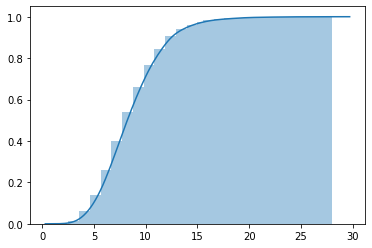

In [12]:
# What's the distribution of the duration of the days between application_date to first_batch_completed_date
import seaborn as sns
duration = (df_transpose['first_batch_completed_date'] - df_transpose['application_date'])
sns.distplot(duration[duration.notna()].dt.days, hist_kws={'cumulative':'True'}, kde_kws= {'cumulative':'True'})

## Sample Size

In [13]:
# defind the conversion windows
# application date range from [2018-10-01 00:00:00, 2018-10-31 00:00:00]  80% -> duration 11 days

qualified_applicant_id = pd.DataFrame(df.loc[(df['event'] == 'application_date') 
                                             & (df['event_date'] <= '2018-10-31'),'applicant_id'].unique())
qualified_applicant_id.columns = ['qualified_applicant_id']

In [14]:
# filter out who are not qualified in this experiment

df = df.merge(qualified_applicant_id,left_on = 'applicant_id', right_on = 'qualified_applicant_id', 
              how = 'inner').reset_index(drop = True)
df = df[['applicant_id','channel','group','city','event','event_date']]
df.head()

,applicant_id,channel,group,city,event,event_date
0,10001,web-search-engine,control,Asgard,application_date,2018-10-01
1,10001,web-search-engine,control,Asgard,card_mailed_date,2018-10-01
2,10001,web-search-engine,control,Asgard,orientation_completed_date,2018-10-03
3,10002,social-media,control,Midgard,application_date,2018-10-01
4,10002,social-media,control,Midgard,card_mailed_date,2018-10-01


In [15]:
# check convertsion funnel

print (df[df['group'] == 'control'].groupby(['group','event']).applicant_id.nunique().sort_values(ascending = False))
print (df[df['group'] == 'treatment'].groupby(['group','event']).applicant_id.nunique().sort_values(ascending = False))

group    event                          
control  card_mailed_date                   10024
         application_date                   10024
         card_activation_date                8582
         background_check_initiated_date     8582
         background_check_completed_date     8465
         orientation_completed_date          4370
         first_batch_completed_date          2678
Name: applicant_id, dtype: int64
group      event                          
treatment  card_mailed_date                   4958
           background_check_initiated_date    4958
           background_check_completed_date    4958
           application_date                   4958
           card_activation_date               4658
           orientation_completed_date         2545
           first_batch_completed_date         2115
Name: applicant_id, dtype: int64


# Checking the invariate metrics
### sample size (function)

In [16]:
# sanity check - sample size
# define invariate check function

def invariant_check(test_sample_size, control_sample_size, p_pool, z_score):
    import numpy as np
    p_pool_sd = np.sqrt(p_pool * (1 - p_pool)/(test_sample_size + control_sample_size))
    margin_error = p_pool_sd * z_score
    control_prop = control_sample_size/(test_sample_size + control_sample_size)
    confidence_interval_lower = p_pool - margin_error
    confidence_interval_upper = p_pool + margin_error   
    return confidence_interval_lower, confidence_interval_upper, control_prop

test_sample = df.groupby('group').agg({'applicant_id': 'nunique'}).loc['treatment','applicant_id']
control_sample = df.groupby('group').agg({'applicant_id': 'nunique'}).loc['control','applicant_id']
lower, upper, control_prop = invariant_check(test_sample,control_sample,0.5,1.96)

print ('confidence interval lower bounds: {}'.format(lower))
print ('confidence interval upper bounds: {}'.format(upper))
print ('control proportion: {}'.format(control_prop))

confidence interval lower bounds: 0.4919935281817871
confidence interval upper bounds: 0.5080064718182129
control proportion: 0.6690695501268189


In [17]:
#if (control_prop >= lower) and (control_prop <= upper):
#    print ('Pass')
#else:
#    print ('Fail')

# Checking the evaluation metric

### Method1 : Calculate z score for pooled two sample data

In [18]:
import scipy.stats as stats

# choose metrics
# conversion rate = complete first batch / application 
# calculate z score

# define z_score function
def z_score_pool(test_success, control_success, test_sample_size, control_sample_size):
    import numpy as np
    d = test_success/test_sample_size - control_success/control_sample_size
    p_pool = (test_success + control_success)/(test_sample_size + control_sample_size)
    p_pool_sd = np.sqrt(p_pool*(1-p_pool)*(1/test_sample_size + 1/control_sample_size))
    z_score = (d-0) / p_pool_sd
    return z_score

test_complete = 2115
contrl_complete = 2678
test_sample_size = 4958
control_sample_size = 10024
alpha = 0.05
dmin = 0  # no prtical significant value provided, then we can assume dmin = 0

z = z_score_pool(test_complete, contrl_complete, test_sample_size, control_sample_size)
p_value = (1-stats.norm.cdf(z))
print ( 'z score is %s > 1.65, so we can reject null hypothesis, and accept alternative hypothesis' %z )
print ( 'or we can say: p value is %s > 0.05, so we can reject null hypothesis, and accept alternative hypothesis' %p_value )

z score is 19.685398121466985 > 1.65, so we can reject null hypothesis, and accept alternative hypothesis
or we can say: p value is 0.0 > 0.05, so we can reject null hypothesis, and accept alternative hypothesis


### Method2 : Calculate z score for unpooled two sample data

In [19]:
import scipy.stats as stats

# choose metrics
# conversion rate = complete first batch / application 
# calculate z score
# define z_score function
def z_score_unpool(test_success, control_success, test_sample_size, control_sample_size):
    import numpy as np
    d = test_success/test_sample_size - control_success/control_sample_size
    p_con = control_success/control_sample_size
    p_test = test_success/test_sample_size
    p_unpool_sd = np.sqrt((p_con*(1-p_con)/control_sample_size) + (p_test*(1-p_test)/test_sample_size))
    z_score = (d-0) / p_unpool_sd
    return z_score


# parameter: 
test_complete = 2115
contrl_complete = 2678
test_sample_size = 4958
control_sample_size = 10024
alpha = 0.05
dmin = 0  # no prtical significant value provided, then we can assume dmin = 0

z = z_score_unpool(test_complete, contrl_complete, test_sample_size, control_sample_size)
p_value = (1-stats.norm.cdf(z))
print ( 'z score is %s > 1.65, so we can reject null hypothesis, and accept alternative hypothesis' %z )
print ( 'or we can say: p value is %s > 0.05, so we can reject null hypothesis, and accept alternative hypothesis' %p_value )

z score is 19.21083008024871 > 1.65, so we can reject null hypothesis, and accept alternative hypothesis
or we can say: p value is 0.0 > 0.05, so we can reject null hypothesis, and accept alternative hypothesis


Note: If the sample size is big enough, there is not much difference between unpool and pool method

### Method3 : Calculate confidence interval

In [20]:
def confidence_interval(test_success, control_success, test_sample_size, control_sample_size):
    import numpy as np
    p_pool = (test_success + control_success)/(test_sample_size + control_sample_size)
    p_pool_sd = np.sqrt(p_pool * (1 - p_pool)/(test_sample_size + control_sample_size))
    margin_error = p_pool_sd * 1.96
    p_con = control_success/control_sample_size
    p_test = test_success/test_sample_size
    diff = p_test - p_con
    confidence_interval_lower = diff - margin_error
    confidence_interval_upper = diff + margin_error   
    return confidence_interval_lower, confidence_interval_upper

#parameters:

# parameter: 
test_complete = 2115
contrl_complete = 2678
test_sample_size = 4958
control_sample_size = 10024
alpha = 0.05
dmin = 0  # no prtical significant value provided, then we can assume dmin = 0

confidence_interval_lower, confidence_interval_upper = confidence_interval(test_complete, contrl_complete, 
                                                                           test_sample_size, control_sample_size)
print ('confidence interval lower is {}'.format(confidence_interval_lower))
print ('confidence interval upper is {}'.format(confidence_interval_upper))
print ( 'confidence interval doesn\'t include 0, so we can reject null hypothesis, and accept alternative hypothesis' %z )

confidence interval lower is 0.15195533610117581
confidence interval upper is 0.16689362566448743
confidence interval doesn't include 0, so we can reject null hypothesis, and accept alternative hypothesis


In [21]:
## metrics2 : t test
## decrease the duration from application to completed first batch

df_transpose = df.pivot_table(index = ['group','channel','applicant_id'],columns = 'event',values = 'event_date', aggfunc='max')
df_transpose['duration'] = (df_transpose['first_batch_completed_date'] - df_transpose['application_date']).dt.days
df_transpose = df_transpose.reset_index()
df_transpose


from scipy import stats
test_duration = df_transpose.loc[(df_transpose['group'] == 'treatment') 
                                 & (df_transpose['duration'].notnull()) ,'duration']
                                    
control_duration = df_transpose.loc[(df_transpose['group'] == 'control')
                                 & (df_transpose['duration'].notnull()) ,'duration']
                                    
t_score = stats.ttest_ind(control_duration,test_duration)
t_score

Ttest_indResult(statistic=39.75542370431981, pvalue=5.822516780864627e-299)

In [22]:
# days from application to first batch completion
df_transpose.groupby('group').agg({'duration':'mean'})

,duration
group,
control,10.176251
treatment,7.076123


# Question 2 
- The background check costs us $30 to complete!  
- We'd like to know if this change is cost-effective. How should we think about the cost-effectiveness of this change? Please be as specific as you can here

In [23]:
cost = 30

# formula: cost per success

control = (30*8582)/ 2678
test =  (30*4958)/ 2115
print (control)
print (test)

96.13890963405527
70.32624113475177


# Question 3

In [24]:
channel_cvr = df_transpose.groupby('channel').agg({'application_date':'count','first_batch_completed_date':'count' })
channel_cvr['cvr'] = channel_cvr['first_batch_completed_date']/channel_cvr['application_date']
channel_cvr.head()

,application_date,first_batch_completed_date,cvr
channel,,,
job-search-site,2625,603,0.229714
shopper-referral-bonus,1991,778,0.390758
social-media,4427,1512,0.341541
web-search-engine,5939,1900,0.319919


In [25]:
channel_cvr_group = df_transpose.groupby(['group','channel']).agg({'application_date':'count','first_batch_completed_date':'count'})
channel_cvr_group['cvr'] = channel_cvr_group['first_batch_completed_date']/channel_cvr_group['application_date']

In [26]:
channel_cvr_group

application_date  \
group     channel                                    
control   job-search-site                     1765   
          shopper-referral-bonus              1332   
          social-media                        2998   
          web-search-engine                   3929   
treatment job-search-site                      860   
          shopper-referral-bonus               659   
          social-media                        1429   
          web-search-engine                   2010   

                                  first_batch_completed_date       cvr  
group     channel                                                       
control   job-search-site                                279  0.158074  
          shopper-referral-bonus                         447  0.335586  
          social-media                                   958  0.319546  
          web-search-engine                              994  0.252991  
treatment job-search-site                                324  0.376744  
          shopper-referral-bonus                         331  0.502276  
          social-media                                   554  0.387684  
          web-search-engine                              906  0.450746

In [27]:
def experiment_size(p_null, p_alt, alpha = .05, beta = .20):
    """
    Compute the minimum number of samples needed to achieve a desired power
    level for a given effect size.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected
        alpha : Type-I error rate
        beta  : Type-II error rate
    
    Output value:
        n : Number of samples required for each group to obtain desired power
    """
    
    # Get necessary z-scores and standard deviations (@ 1 obs per group)
    import numpy as np
    z_null = stats.norm.ppf(1 - alpha)
    z_alt  = stats.norm.ppf(beta)
    sd_null = np.sqrt(p_null * (1-p_null) + p_null * (1-p_null))
    sd_alt  = np.sqrt(p_null * (1-p_null) + p_alt  * (1-p_alt) )
    
    # Compute and return minimum sample size
    p_diff = p_alt - p_null
    n = ((z_null*sd_null - z_alt*sd_alt) / p_diff) ** 2
    return np.ceil(n)

In [28]:
test_complete = 2115
contrl_complete = 2678
test_sample_size = 4958
control_sample_size = 10024

base_null = 2678/10024
p_alt = 2115/4958

experiment_size(base_null, p_alt)

100.0